In [1]:
import pandas as pd
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns
from collections import OrderedDict, defaultdict

import cvxpy as cp

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) May 10 09:50:34 AM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy.core.multiarray failed to import')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) May 10 09:50:34 AM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy.core.multiarray failed to import')


In [2]:
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier

## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [3]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2013,1,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  504 of 504 completed

41 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- OTIS: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- CDW: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- HLT: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- CZR: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- ETSY: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- SYF: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- NWSA: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- ZTS: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- TWTR: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- BF.B: No data found for this date range, symbol may be delisted
- PYPL: Data doesn't exist for startDate = 946702800, endDate = 1357016400
- CDAY: Data doesn't exist for startDate = 9467

In [4]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)

## Testing Initial Portfolio without Bayes

In [5]:
five_year_data=SP_Close[:1265] #5 years of data
five_year_data.tail(1)

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-13,13.333962,1.065719,11.161538,12.45,14.665898,29.10429,23.122831,14.69219,21.719233,31.763618,...,36.948322,7.074917,10.605625,13.686287,9.298725,28.619404,24.669783,11.911841,51.060001,48.831837


## Look at some correlations and clustering to gather ideas

In [6]:
corr = five_year_data.corr()
#plt.figure(figsize=(12,8))
#sns.clustermap(corr)

In [7]:
import scipy.cluster.hierarchy as shc
#dimensions = SP_Close.shape[1]
#plt.figure(figsize=(10, 7))  
#plt.title("Dendrograms")  
#dend = shc.dendrogram(shc.linkage(corr, method='ward'))

## Clustering algorithm using rule: select minimum number of clusters such that at most stock_pct_thresh of stocks are in clusters with an internal corr of corr_thresh

In [8]:
from sklearn.cluster import AgglomerativeClustering

class constrained_clusterings_new:
    # Initialize with  AAA = constrained_clusterings_new(correlation_matrix)
    # Call with        optimal_num_clusters = AAA.calcthresholds(self,corr_threshold,pct_threshold)
    
    # Optimal number of clusters calculated via:
    # Minimum number of clusters s.t.
    #   (Percent of stocks in clusters with internal correlation less than corr_threshold) is less than pct_threshold
    
    def __init__(self,corr):
        self.corr = corr                     # correlation matrix
        self.sz = corr.shape[0]              # size
        
        self.__precompute()
        
        self.names = pd.DataFrame(corr.columns.values) # stock names
        
    def __precompute(self):
        sz = self.sz
        corr_np = np.array(self.corr)
        
        self.clusters = np.zeros((sz,sz))    # cluster assignments of stocks
        self.numstocks = np.zeros((sz,sz))   # stocks per cluster
        self.internals = np.zeros((sz,sz))   # internal correlations of clusters
        
        for i in range(sz):
            clusters_tmp = AgglomerativeClustering(n_clusters=i+1, affinity='euclidean', linkage='ward').fit_predict(corr_np)
            self.clusters[i,:] = clusters_tmp
            numstocks_tmp = np.zeros(sz)
            internals_tmp = np.zeros(sz)
            for j in range(i+1):
                numstocks_tmp[j] = np.sum(clusters_tmp==j)
                tmpcorr = corr_np[clusters_tmp==j]
                tmpcorr = tmpcorr[:,clusters_tmp==j]
                internals_tmp[j] = np.mean(tmpcorr)
            self.numstocks[i,:] = numstocks_tmp
            self.internals[i,:] = internals_tmp
            
    def calcthresholds(self,corr_threshold,pct_threshold, show=False):
        tmp = np.sum((self.internals<corr_threshold)*(self.numstocks/self.sz),axis=1)<pct_threshold
        ret = (np.arange(0,self.sz)+1)[tmp]
        if show == True:
            print("Valid numbers of clusters:")
            print(ret)
        if ret.shape[0] <= 0:
            return None
        return ret[0]
    
def get_clusters(corr, cluster_number = 45, Thresh = None):
    if Thresh == None:
        cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=Thresh)
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    return stock_clusters

In [9]:
clustering_obj = constrained_clusterings_new(corr)

incCorrThresh = .05 
CorrThreshRange = np.arange(incCorrThresh,1,incCorrThresh)

incPctThresh = .05
PctThreshRange = np.arange(incPctThresh,.5,incPctThresh)

arr = np.zeros([19,9])
for posi, i in enumerate(CorrThreshRange):
    for posj, j in enumerate(PctThreshRange):
        arr[posi,posj] = clustering_obj.calcthresholds(i,j)

In [10]:
# y is corr thresh
# x is pct threshold
pd.DataFrame(arr, index=np.round(CorrThreshRange,3).astype(str),columns = np.round(PctThreshRange,3).astype(str))

,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45
0.05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
0.35,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
0.4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
0.45,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
0.5,12.0,11.0,11.0,7.0,5.0,2.0,2.0,2.0,2.0


## backtest

In [11]:
#shrinkage
def calculate_posterior_mean(like_pop, prior_pop): #for returns use geo mean then nultiply by 252 to annualize at end
    w0 = prior_pop.std()
    mu0 = prior_pop.mean() - w0**2/2
    w = like_pop.std()
    dbar = like_pop.mean() - w**2/2

    # Prior:
    prior = stats.norm(mu0, w0)
    
    # Likelihood:
    like = stats.norm(dbar, w)
    
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s * 252

## Markowitz Rebalancer

In [12]:
def Markowits_Bayes_Rebalance(securities_vector, 
                              rebalance_period,
                              prior_period,
                              update_period=0,
                              weight_bounds=(-.01,.1),
                              cluster_num = 44,
                              mean_shrink = False, 
                              corr_shrink = True):
    weights_list=[]
    dates=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period): #
        prior_vector = securities_vector[p:prior_period+p]
        mu = mean_historical_return(prior_vector)             
        if mean_shrink == True:
            clusters = get_clusters(prior_vector.corr(), cluster_number = cluster_num)
            for i in range(cluster_num):
                stocksNcluster = clusters.loc[clusters['cluster']==i].index
                for stock in stocksNcluster:
                    mu.loc[stock] = calculate_posterior_mean(five_year_data[stock].pct_change().dropna().to_numpy(),
                                                             five_year_data[stocksNcluster].pct_change().dropna().to_numpy())
        if corr_shrink == True:
            S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        else:
            S = sample_cov(prior_vector)                          #is this right?
            
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df

In [13]:
monthly_vanilla_markowitz_weights = Markowits_Bayes_Rebalance(SP_Close,21,252*5) #monthly rebalance with 5 year matrix
return_frame = SP_Close.loc[monthly_vanilla_markowitz_weights.index]
return_frame = np.exp(np.log(return_frame).diff())-1
weighted_returns=monthly_vanilla_markowitz_weights.shift(1)*return_frame
port_returns = np.sum(weighted_returns, axis=1).rename('Vanilla')

In [14]:
monthly_shrunk_markowitz_weights = Markowits_Bayes_Rebalance(SP_Close,21,252*5, cluster_num = 43, mean_shrink = True) #monthly rebalance with 5 year matrix
return_shrunk_frame = SP_Close.loc[monthly_shrunk_markowitz_weights.index]
return_shrunk_frame = np.exp(np.log(return_shrunk_frame).diff())-1
weighted_shrunk_returns=monthly_shrunk_markowitz_weights.shift(1)*return_shrunk_frame
port_shrunk_returns = np.sum(weighted_shrunk_returns, axis=1).rename('shrunk')

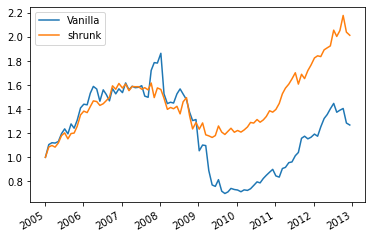

In [16]:
(pd.concat([port_returns,port_shrunk_returns],axis=1)+1).cumprod().plot()
plt.show()